# Fit Convergent Cross Mapping Model to Data Sets

In this file, it includes two main parts which are fitting CCM based on State wise and Country wise. Also, there are three models respectively:
1. Alcohol establishments against total rape
2. Alcohol establishments against shifted total rape
3. Alcohol establishments against misogyny tweets

In [210]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [224]:
# from 2012-2020 9 years in total, 12 months for each year
merged_data = pd.read_csv('./data/merged_data.csv',index_col=0)
merged_data = merged_data.sort_values(by=['year','month'],ascending=[True, True])

In [226]:
merged_data.head()

,USstate,year,month,nTweets_x,nTweets_y,Number of establishments (ESTAB),abbr,full,population,actual_rape_total
0,al,2012,1,51744.000000,3.00,367.0,al,Alabama,4834334,106
108,ak,2012,1,20125.600000,1.35,101.0,ak,Alaska,735190,39
216,az,2012,1,57016.090909,1.00,208.0,az,Arizona,6572455,205
324,ar,2012,1,7733.000000,1.00,318.0,ar,Arkansas,2981157,108
432,ca,2012,1,134228.000000,5.00,3733.0,ca,California,38183375,671


# Part A: State-wise

In [225]:
state_list = list(set(merged_data['USstate'].to_list()))
print(len(state_list))

46


## 1. Quick View

### i). Total Rape Crime

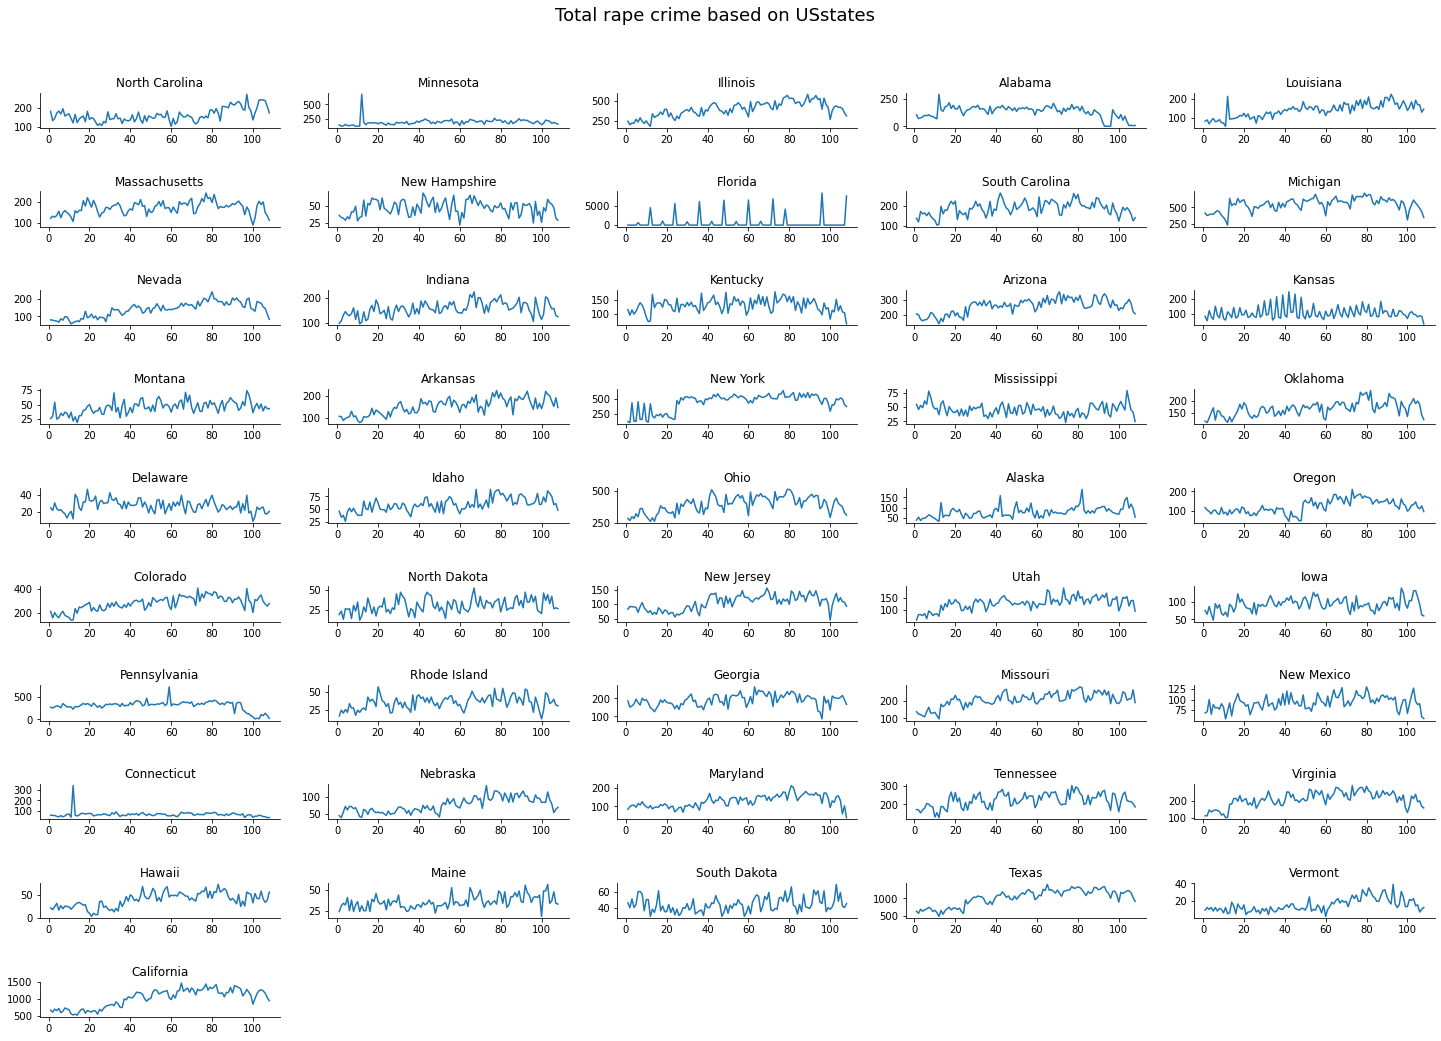

In [240]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Total rape crime based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()

    x1_rape_total = data['actual_rape_total'].to_numpy()

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x1_rape_total)
    ax.set_title(curr_state)
    sns.despine()

### ii). Shifted Rape Crime

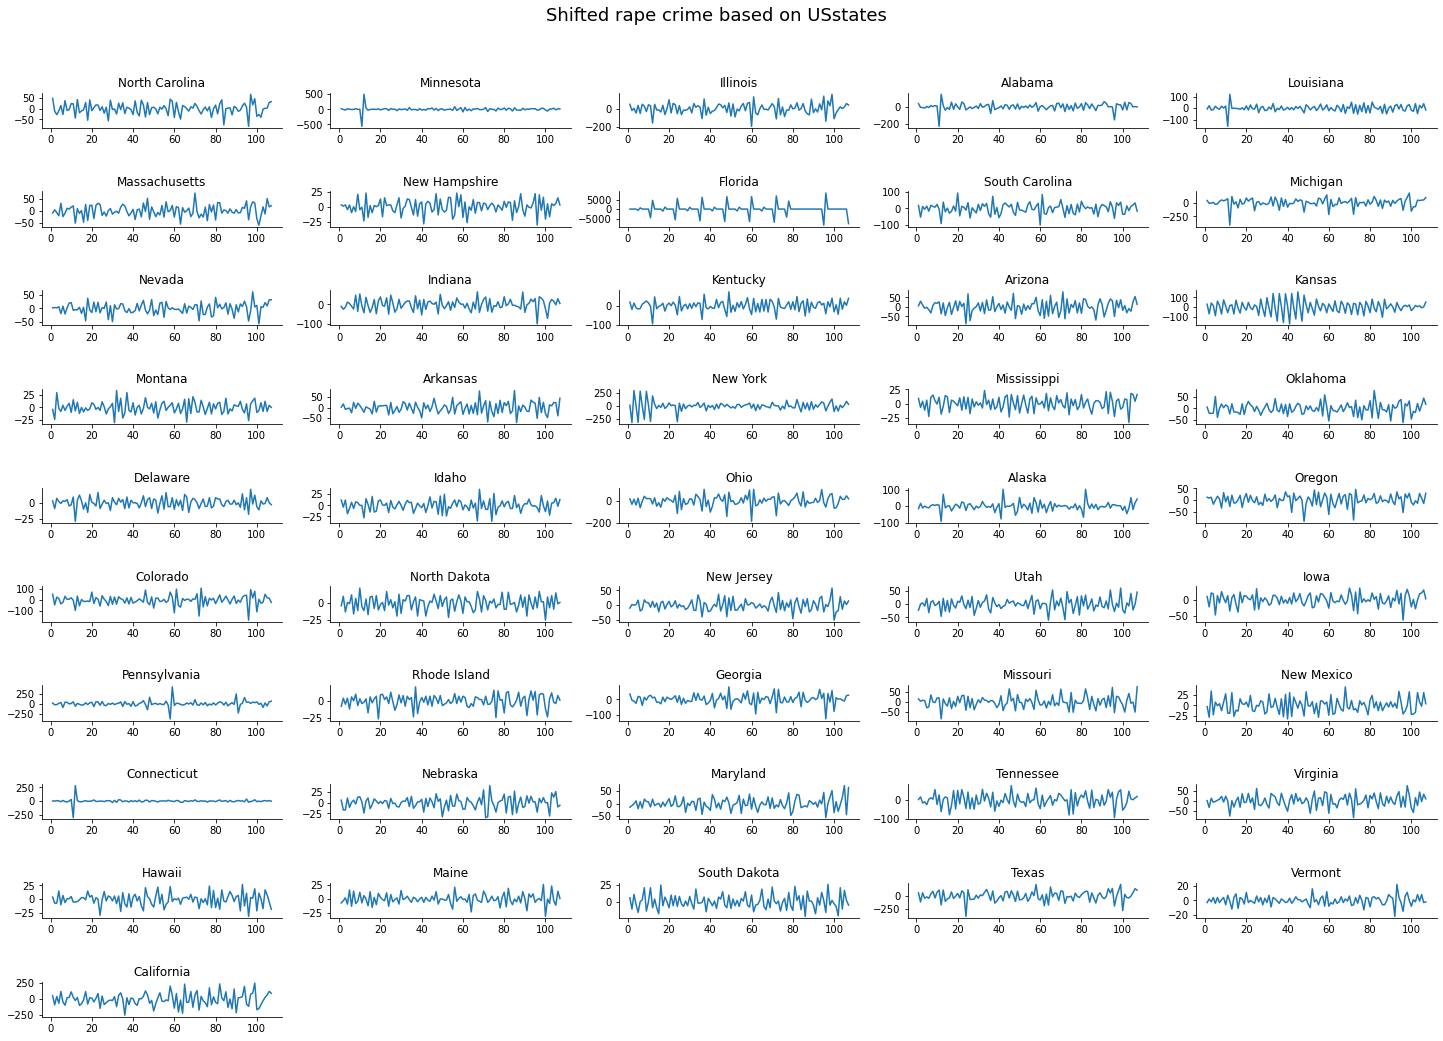

In [241]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Shifted rape crime based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_rape_total'] = data['actual_rape_total'] - data['actual_rape_total'].shift(-1)

    x1_shifted_rape_total = data['shifted_rape_total'].to_numpy()

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x1_shifted_rape_total)
    ax.set_title(curr_state)
    sns.despine()

### iii). Misogyny tweets

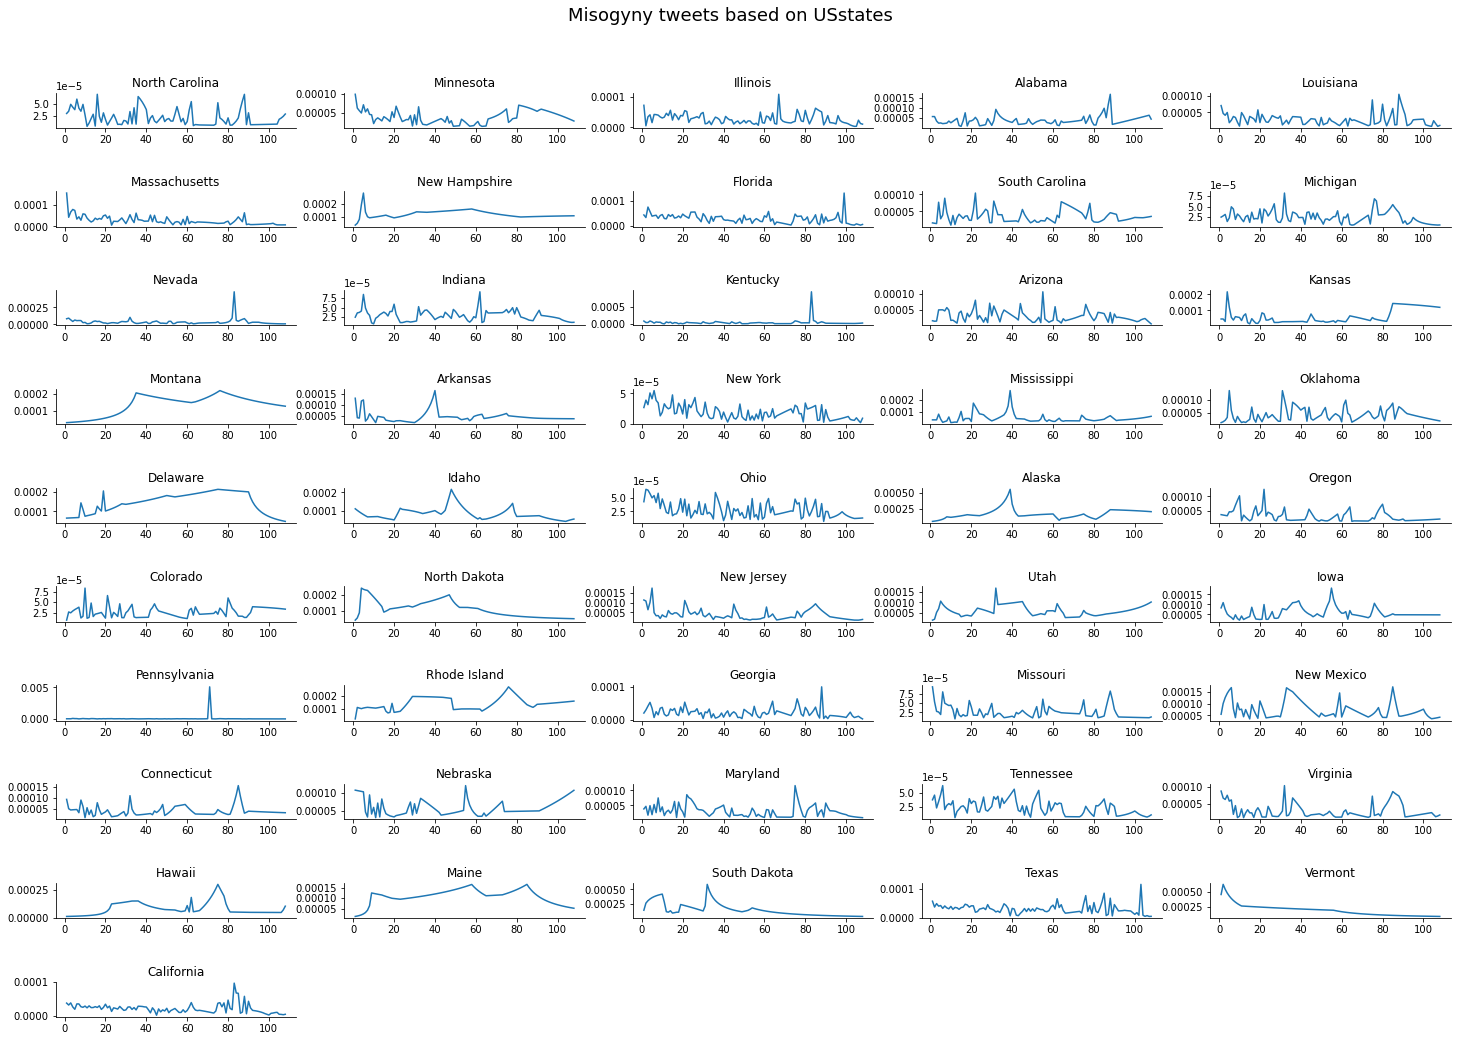

In [242]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Misogyny tweets based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    x2_misogyny_proportion = data['misogyny_proportion'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x2_misogyny_proportion)
    ax.set_title(curr_state)
    sns.despine()

### iv). Alcohol Establishments

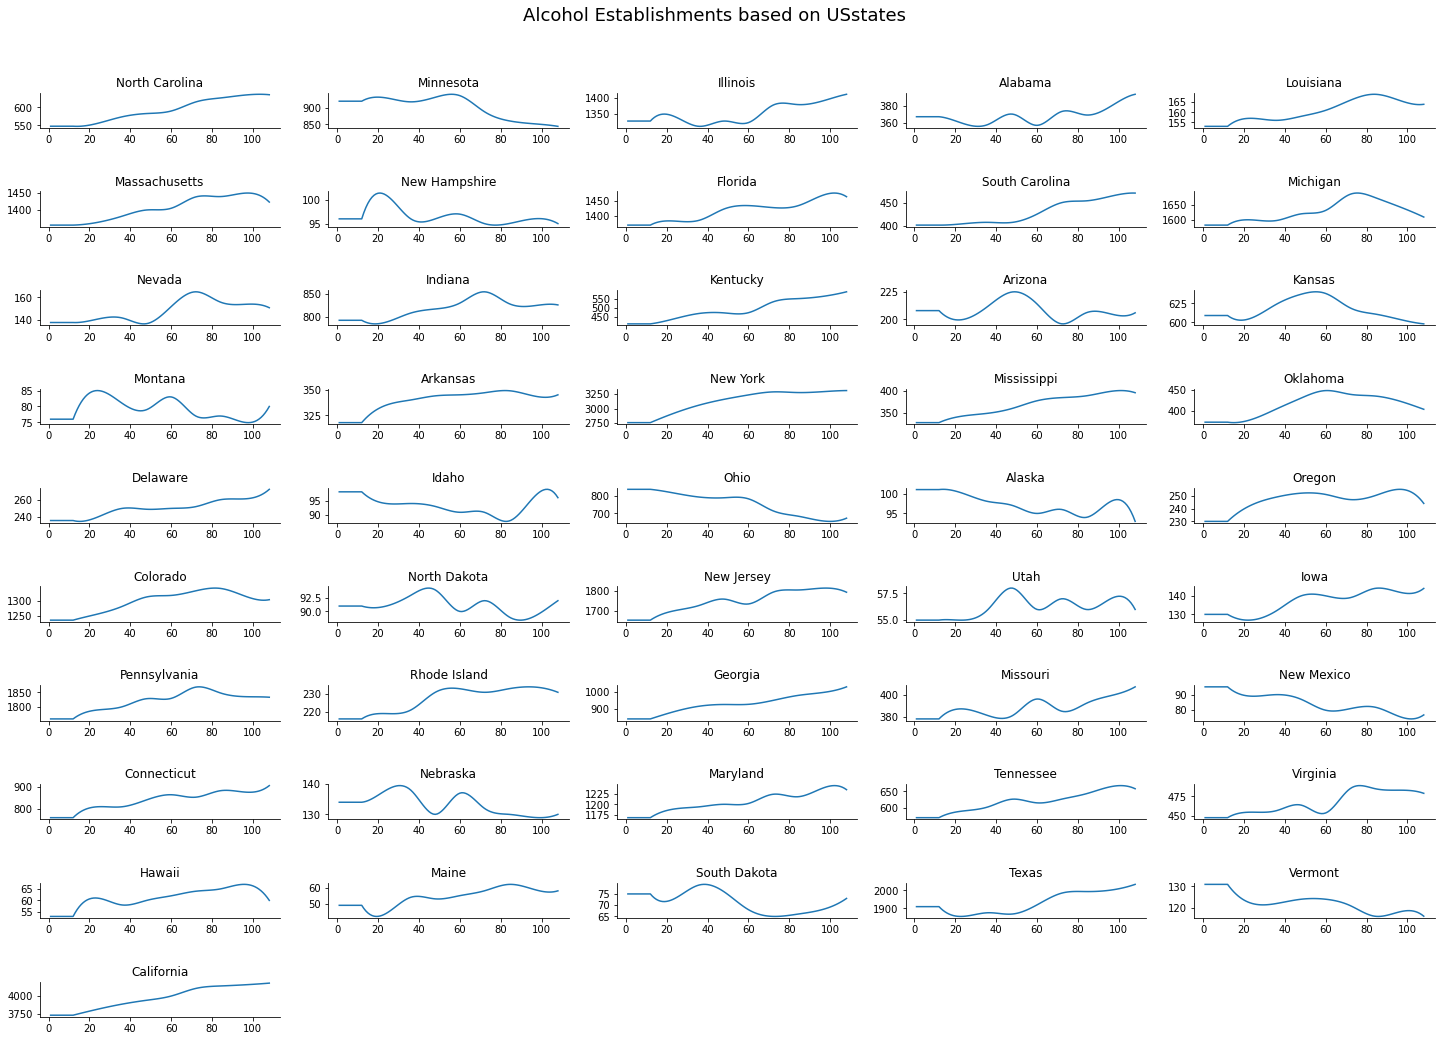

In [309]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Alcohol Establishments based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    
    x3_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x3_alcohol)
    ax.set_title(curr_state)
    sns.despine()

### v). Shifted Alcohol Establishments

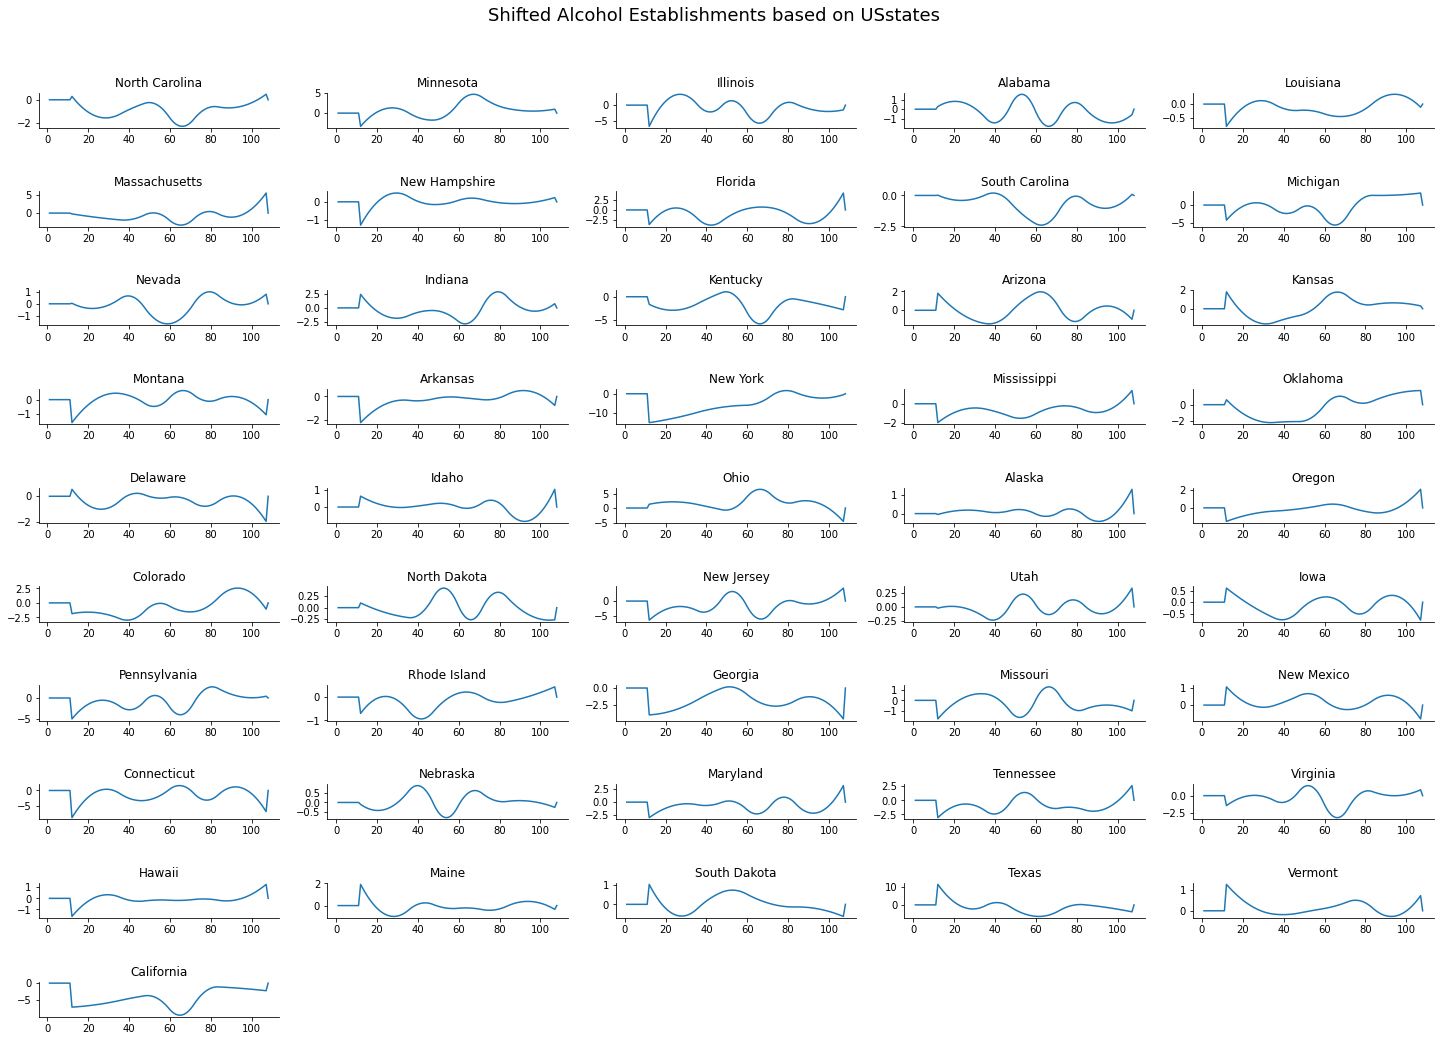

In [315]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Shifted Alcohol Establishments based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_alcohol'] = data['Number of establishments (ESTAB)'] - data['Number of establishments (ESTAB)'].shift(-1)
    data['shifted_alcohol'] = data['shifted_alcohol'].fillna(0)
    
    x3_alcohol = data['shifted_alcohol'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x3_alcohol)
    ax.set_title(curr_state)
    sns.despine()

## 2. Fit CCM

### i). Alcohol vs Crime

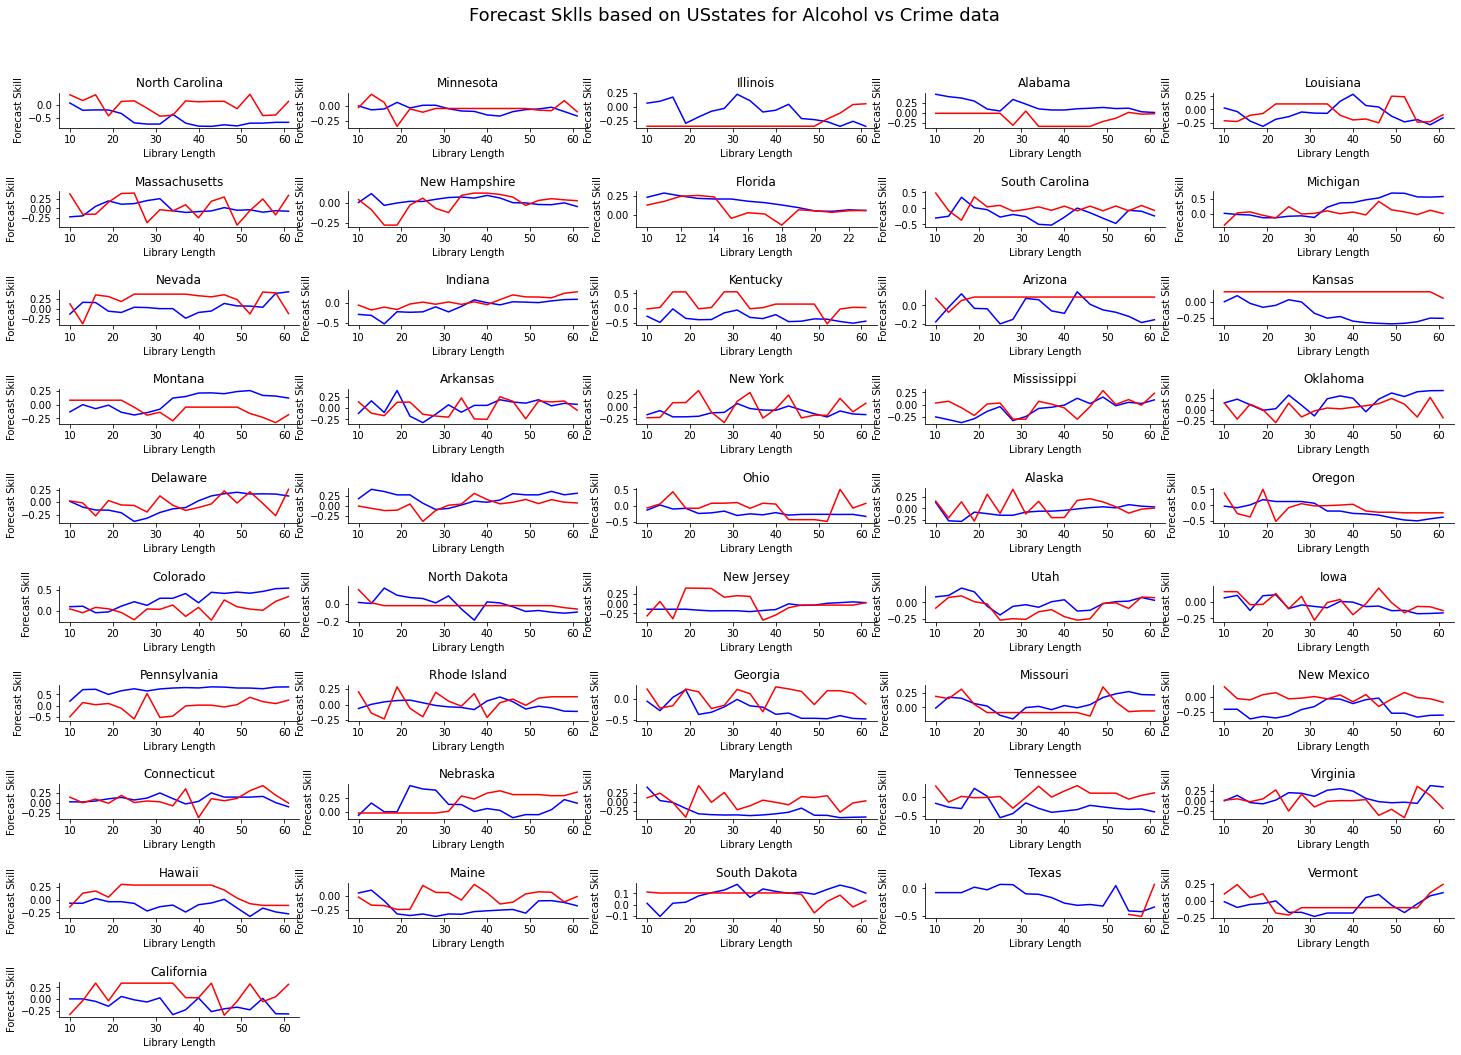

In [236]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates for Alcohol vs Crime data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    x2_crime = data['actual_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

### ii). Shifted Alcohol vs Shifted Crime

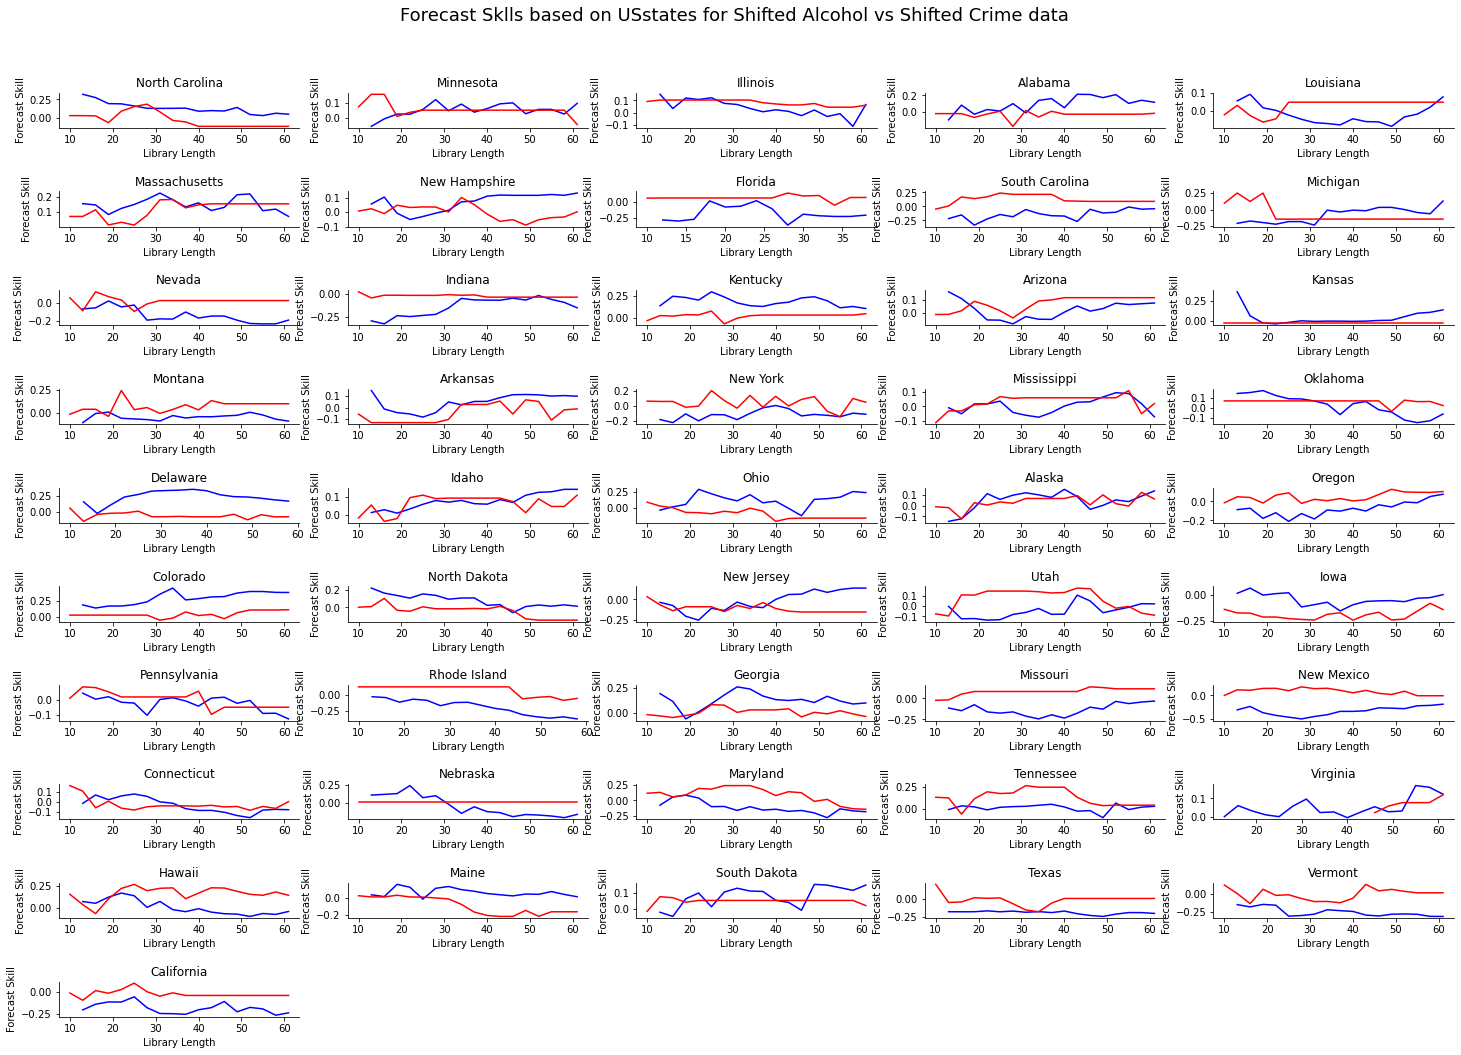

In [316]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates for Shifted Alcohol vs Shifted Crime data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_rape_total'] = data['actual_rape_total'] - data['actual_rape_total'].shift(-1)
    data['shifted_rape_total'] = data['shifted_rape_total'].fillna(0)
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['shifted_alcohol'] = data['Number of establishments (ESTAB)'] - data['Number of establishments (ESTAB)'].shift(-1)
    data['shifted_alcohol'] = data['shifted_alcohol'].fillna(0)
    
    # 0. extract data
    x1_alcohol = data['shifted_alcohol'].to_numpy()
    x2_rape_total = data['shifted_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_rape_total)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_rape_total, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # shifted alcohol predict shifted crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # shifted crime predict shifted alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

### iii). Shifted Alcohol vs Tweets

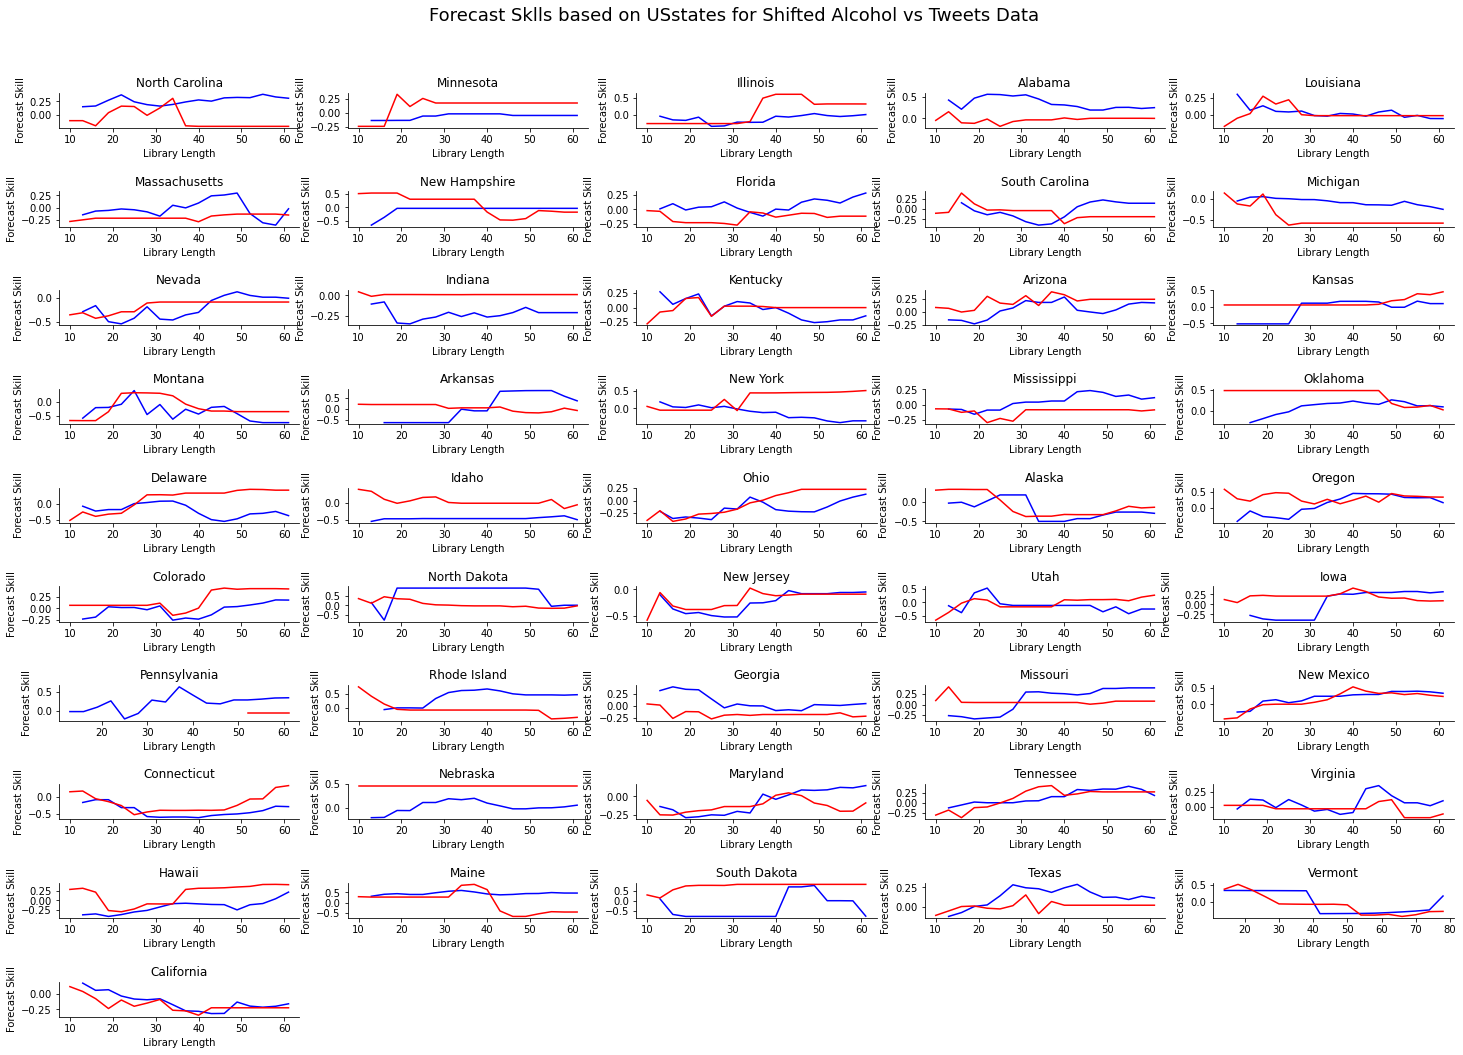

In [317]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates for Shifted Alcohol vs Tweets Data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['shifted_alcohol'] = data['Number of establishments (ESTAB)'] - data['Number of establishments (ESTAB)'].shift(-1)
    data['shifted_alcohol'] = data['shifted_alcohol'].fillna(0)
    
    # 0. extract data
    x1_alcohol = data['shifted_alcohol'].to_numpy()
    x2_tweet = data['misogyny_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_tweet)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_tweet, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # shifted alcohol predict tweets
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict shifted alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

# Part B: Country-wise

In [318]:
merged_data10 = merged_data
merged_data10['misogyny_proportion'] = merged_data10['nTweets_y'] / merged_data10['nTweets_x']
merged_data10 = merged_data10.groupby(['year','month']).sum()
merged_data10['shifted_rape_total'] = merged_data10['actual_rape_total'] - merged_data10['actual_rape_total'].shift(-1)
merged_data10['shifted_rape_total'] = merged_data10['shifted_rape_total'].fillna(0)
merged_data10['shifted_alcohol'] = merged_data10['Number of establishments (ESTAB)'] - merged_data10['Number of establishments (ESTAB)'].shift(-1)
merged_data10['shifted_alcohol'] = merged_data10['shifted_alcohol'].fillna(0)
merged_data10 = merged_data10.drop(columns=['nTweets_x','nTweets_y','population'])
merged_data10

Number of establishments (ESTAB)  actual_rape_total  \
year month                                                        
2012 1                          31125.000000               5989   
     2                          31125.000000               5496   
     3                          31125.000000               6413   
     4                          31125.000000               5962   
     5                          31125.000000               6238   
...                                      ...                ...   
2020 8                          33680.338636               9553   
     9                          33684.559385               9070   
     10                         33687.191145               8585   
     11                         33688.061992               7681   
     12                         33687.000000              14338   

            misogyny_proportion  shifted_rape_total  shifted_alcohol  
year month                                                            
2012 1                 0.002996               493.0         0.000000  
     2                 0.003072              -917.0         0.000000  
     3                 0.003044               451.0         0.000000  
     4                 0.003859              -276.0         0.000000  
     5                 0.003852              -969.0         0.000000  
...                         ...                 ...              ...  
2020 8                 0.001956               483.0        -4.220749  
     9                 0.001983               485.0        -2.631760  
     10                0.001989               904.0        -0.870847  
     11                0.001992             -6657.0         1.061992  
     12                0.002031                 0.0         0.000000  

[108 rows x 5 columns]

## 0. Extract data

In [319]:
x1_alcohol = merged_data10['Number of establishments (ESTAB)'].to_numpy()
x2_crime = merged_data10['actual_rape_total'].to_numpy()
x3_tweet = merged_data10['misogyny_proportion'].to_numpy()
x4_shifted_crime = merged_data10['shifted_rape_total'].to_numpy()
x5_shifted_alcohol = merged_data10['shifted_alcohol'].to_numpy()

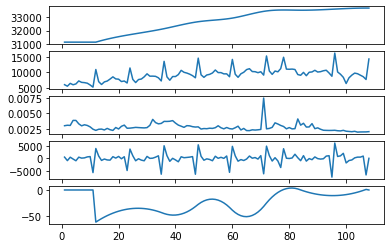

In [320]:
fig,ax = plt.subplots(nrows=5,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_alcohol)
ax[1].plot(np.arange(1,109),x2_crime)
ax[2].plot(np.arange(1,109),x3_tweet)
ax[3].plot(np.arange(1,109),x4_shifted_crime)
ax[4].plot(np.arange(1,109),x5_shifted_alcohol)

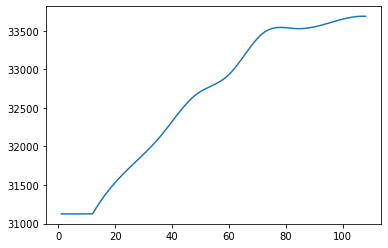

In [312]:
plt.plot(np.arange(1,109),x1_alcohol)

In [321]:
corr = merged_data10.corr() #reference correlation
corr

,Number of establishments (ESTAB),actual_rape_total,misogyny_proportion,shifted_rape_total,shifted_alcohol
Number of establishments (ESTAB),1.000000,0.600077,-0.207433,-0.003107,0.340021
actual_rape_total,0.600077,1.000000,-0.144334,0.532745,0.026308
misogyny_proportion,-0.207433,-0.144334,1.000000,-0.172147,-0.054937
shifted_rape_total,-0.003107,0.532745,-0.172147,1.000000,-0.059928
shifted_alcohol,0.340021,0.026308,-0.054937,-0.059928,1.000000


## i). Alcohol vs Crime

## 1. Calculate Mutual information

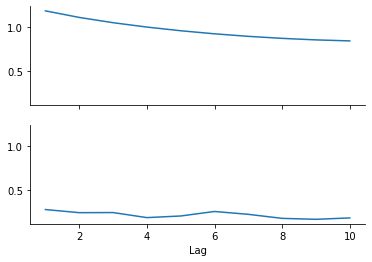

In [253]:
e1 = ccm.Embed(x1_alcohol)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

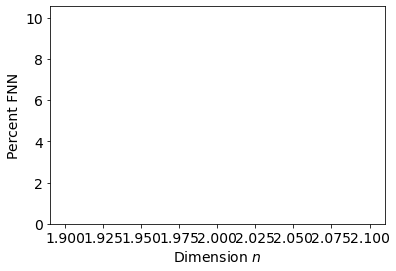

FNN embedding Dimension:  2


In [255]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x2_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

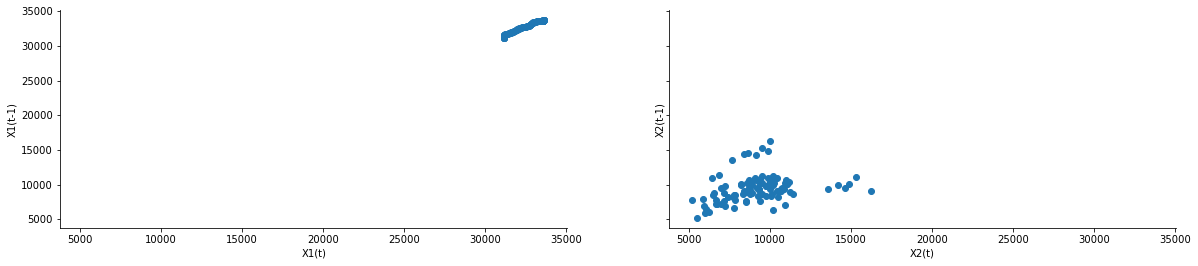

In [256]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

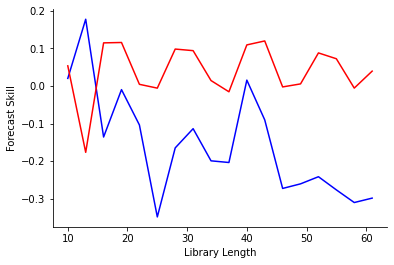

In [259]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

## ii). Shifted Alcohol vs Shifted Crime

## 1. Calculate Mutual information

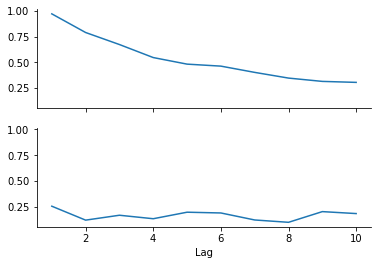

In [322]:
e1 = ccm.Embed(x5_shifted_alcohol)
e2 = ccm.Embed(x4_shifted_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

9


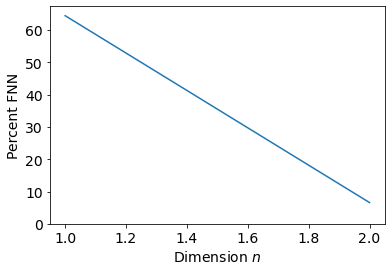

FNN embedding Dimension:  2


In [323]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x4_shifted_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

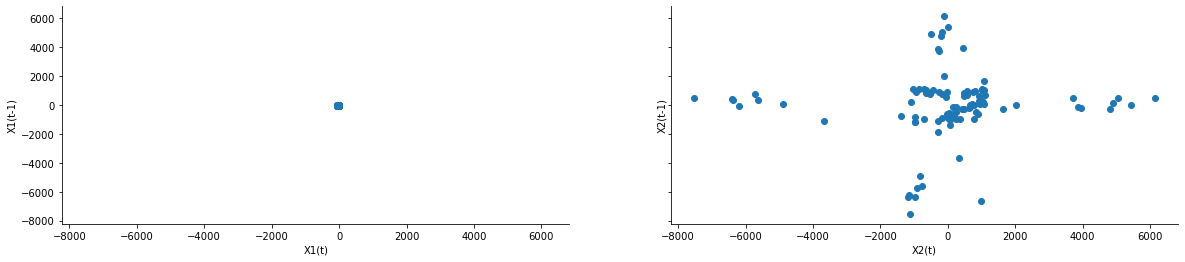

In [324]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

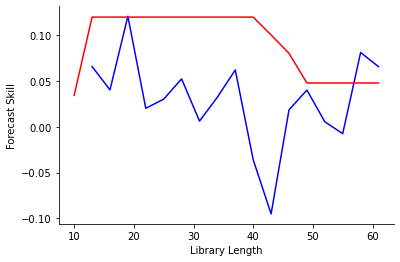

In [325]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # shifted alcohol predict shifted crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # shifted crime predict shifted alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

## iii). Shifted Alcohol vs Tweets

## 1. Calculate Mutual information

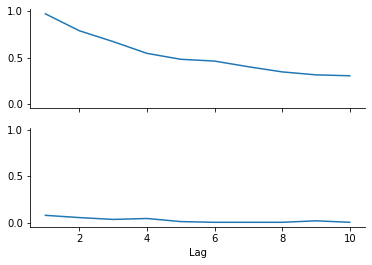

In [326]:
e1 = ccm.Embed(x5_shifted_alcohol)
e2 = ccm.Embed(x3_tweet)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

9


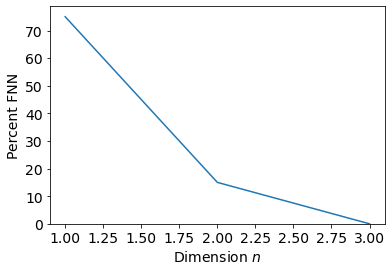

FNN embedding Dimension:  3


In [327]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x3_tweet, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

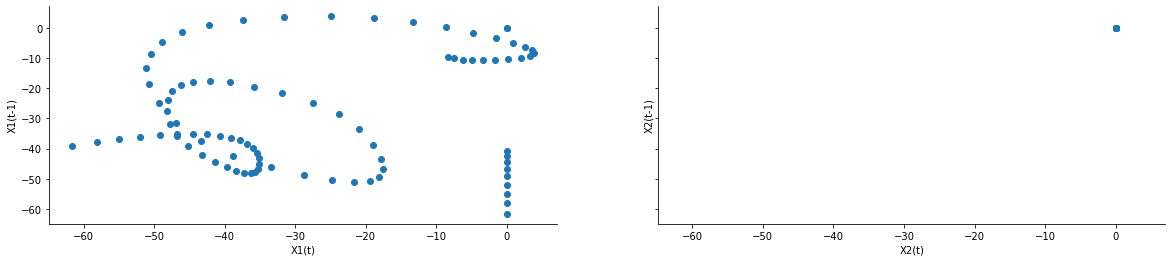

In [328]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

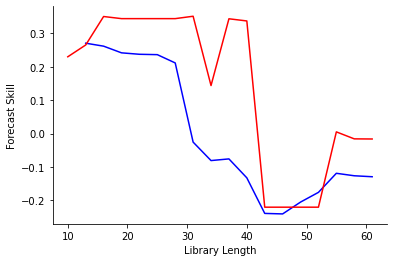

In [329]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # Shifted alcohol predict tweets
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict shifted alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()